In [10]:
import torch
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [11]:
data_dir = 'datasets_Cats_vs_Dogs'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加載數據集
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

val_dataset = datasets.ImageFolder('datasets_Cats_vs_Dogs/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes

In [12]:
import timm
import torch.nn as nn

# 加載預訓練的ConvNeXt模型
model = timm.create_model('convnext_tiny', pretrained=True)

# 檢查並打印模型的頭部
print(model.head)

# 修改最後的分類層
if isinstance(model.head, nn.Linear):
    model.head = nn.Linear(model.head.in_features, 2)
else:
    # 如果不是單一線性層，則需要逐層修改
    model.head.fc = nn.Linear(model.head.fc.in_features, 2)


NormMlpClassifierHead(
  (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Identity())
  (norm): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (pre_logits): Identity()
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=768, out_features=1000, bias=True)
)


In [4]:
model

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


In [6]:
import torch.optim as optim

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 5
best_accuracy = 0
best_model_path = ''

train_losses = []
test_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # 訓練損失
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # 測試準確率
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)
    
    # 驗證準確率
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model_path = f'2_ConvNeXt_model_epoch_{epoch}.pth'
        torch.save(model.state_dict(), best_model_path)
        
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Test Acc: {test_accuracy:.2f}, Val Acc: {val_accuracy:.2f}')

if best_model_path:
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    print(f'Loaded best model from: {best_model_path}')
else:
    print('No best model found.')



Epoch 1, Loss: 0.0604, Test Acc: 98.70, Val Acc: 98.50
Epoch 2, Loss: 0.0309, Test Acc: 98.74, Val Acc: 98.80
Epoch 3, Loss: 0.0307, Test Acc: 98.46, Val Acc: 98.65
Epoch 4, Loss: 0.0223, Test Acc: 98.62, Val Acc: 98.83
Epoch 5, Loss: 0.0219, Test Acc: 98.54, Val Acc: 98.72
Loaded best model from: 2_ConvNeXt_model_epoch_1.pth


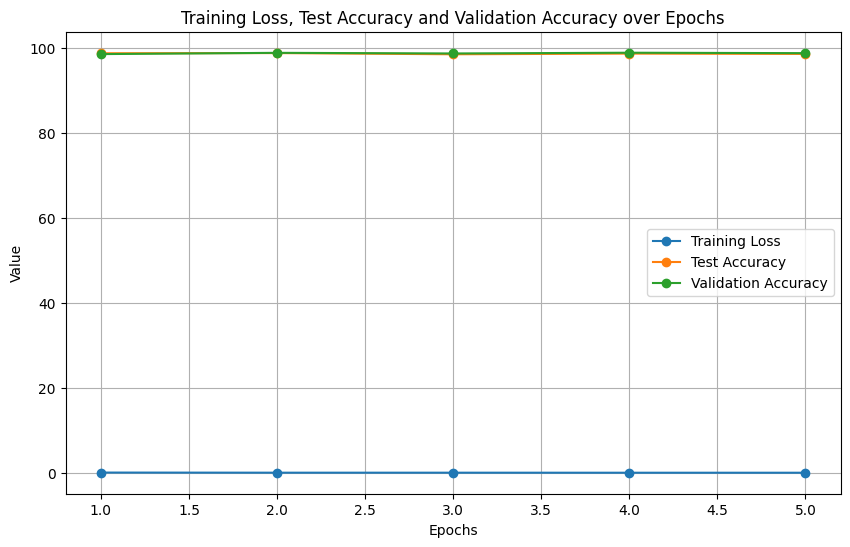

In [7]:
import matplotlib.pyplot as plt

# 繪製訓練損失、測試準確率和驗證準確率的圖表
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss, Test Accuracy and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import torch
import gc

# 釋放 GPU 記憶體
def free_memory():
    torch.cuda.empty_cache()
    gc.collect()
    
# 刪除模型變量
del model
del optimizer
del criterion

# 調用垃圾回收
gc.collect()
torch.cuda.empty_cache()


In [14]:
model.load_state_dict(torch.load('2_ConvNeXt_model_epoch_1.pth'))
model.eval()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


Dog


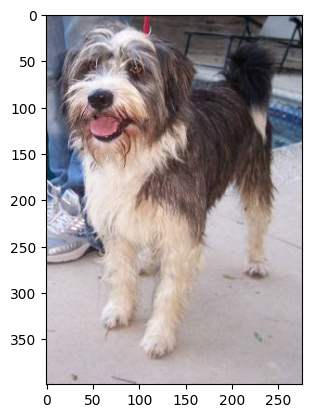

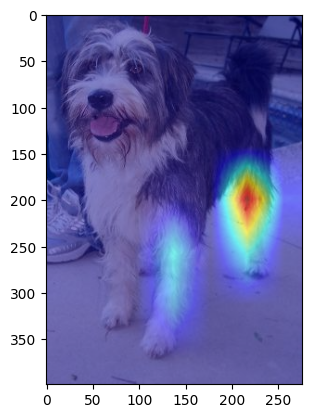

In [30]:
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0)
    return img

def predict(image_path, model):
    img_tensor = preprocess_image(image_path).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output.data, 1)
    return 'Cat' if predicted.item() == 0 else 'Dog'

def generate_cam(model, target_layer, img_tensor, class_idx=None):
    model.eval()
    feature_maps = []
    gradients = []

    def forward_hook(module, input, output):
        feature_maps.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # 選擇目標層
    target_layer = target_layer

    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    output = model(img_tensor)
    if class_idx is None:
        class_idx = torch.argmax(output).item()

    model.zero_grad()
    class_loss = output[0, class_idx]
    class_loss.backward()

    handle_forward.remove()
    handle_backward.remove()

    feature_map = feature_maps[0].detach().cpu().numpy()[0]
    gradient = gradients[0].detach().cpu().numpy()[0]

    weights = np.mean(gradient, axis=(1, 2))
    cam = np.sum(weights[:, np.newaxis, np.newaxis] * feature_map, axis=0)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = cv2.resize(cam, (img_tensor.size(2), img_tensor.size(3)))

    return cam

def show_cam_on_image(img_path, cam):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    cam = 1 - cam
    
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    superimposed_img = heatmap + np.float32(img) / 255
    superimposed_img = superimposed_img / np.max(superimposed_img)
    plt.imshow(np.uint8(255 * superimposed_img))
    plt.show()

image_path = 'datasets_Cats_vs_Dogs/val/Dogs/dog.3102.jpg'
print(predict(image_path, model))
plt.imshow(plt.imread(image_path))
plt.show()

# 選擇 ConvNeXt 的目標層
# 這裡選擇了最後一個 stage 的第一個 block 作為例子
target_layer = model.stages[3].blocks[0].conv_dw

img_tensor = preprocess_image(image_path).to(device)

cam = generate_cam(model, target_layer, img_tensor)

show_cam_on_image(image_path, cam)